##Imports

In [23]:
%pip install yfinance
%pip install keras
%pip install tensorflow
%pip install transformers
%pip install torch
%pip install reservoirpy
%pip install seaborn
%pip install matplotlib
%pip install numpy 
%pip install pandas
%pip install scikit-learn
%pip install backtesting
%pip install keras-tuner -q
%pip install scikeras
import scikeras
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import reservoirpy as rpy
import torch
import datetime
import seaborn as sns
import tensorflow as tf
import random
import yfinance as yf
import time
import keras
import keras_tuner
from tensorflow.keras import layers, models, optimizers, losses
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, Dense, SimpleRNN, Dropout, GRU, Bidirectional, LayerNormalization
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from reservoirpy.nodes import Reservoir, Ridge
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.preprocessing import StandardScaler
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA
from scipy import stats


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


#Data Processing

In [3]:
news = pd.read_excel("C:\\Users\\fatema\\Downloads\\FM\\News.xlsx")
news[["Date", "Author"]] = news["Date"].str.split('|', expand=True)
news = news.drop(columns=["Author"])
news.set_index("Date", inplace=True)
news.index = news.index.str.strip()
news.index = pd.to_datetime(news.index, format='%b %d, %Y at %H:%M', errors='coerce')
news.index = news.index.strftime('%d-%m-%Y')
news.head()

,Headline
Date,
21-06-2024,California Senator Revives $15 Billion Oil Div...
21-06-2024,India's Oil Imports Surge: Russia Hits Record ...
21-06-2024,Gas Flows to Sabine Pass LNG Export Plant Drop...
21-06-2024,Norway To Consider Developing Nuclear Energy
21-06-2024,India Seeks Tighter Regulatory Control Over LN...


In [4]:
model = AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3, force_download=True)
tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-tone')
#Labels: 0: Neutral, 1: Positive, 2: Negative

def calculate_sentiment(text):
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )
    outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
    scores = torch.nn.functional.softmax(outputs.logits, dim=1)
    sentiment_score = (scores[:, 1]-scores[:,2]).item()
    return sentiment_score

# Apply the function to each row in the DataFrame
news['sentiment_score'] = news['Headline'].apply(calculate_sentiment)

news.head()

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

C:\Users\fatema\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\fatema\.cache\huggingface\hub\models--yiyanghkust--finbert-tone. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

,Headline,sentiment_score
Date,,
21-06-2024,California Senator Revives $15 Billion Oil Div...,-0.000079
21-06-2024,India's Oil Imports Surge: Russia Hits Record ...,0.999967
21-06-2024,Gas Flows to Sabine Pass LNG Export Plant Drop...,-0.999995
21-06-2024,Norway To Consider Developing Nuclear Energy,-0.000718
21-06-2024,India Seeks Tighter Regulatory Control Over LN...,0.999053


In [7]:
news=news.drop(columns=["Headline"])
news.index = pd.to_datetime(news.index)
news = news.resample('D').mean()
news.index=news.index.strftime("%d-%m-%Y")
news.head()
df = yf.download('CL=F', start='2011-06-15', end='2024-06-21')
df=df[["Open","Adj Close"]]
df.index = pd.to_datetime(df.index)
df.index=df.index.strftime("%d-%m-%Y")
df=df.join(news)
df=df.dropna()
df.head()
df=df.dropna()
df.head()
M=df["Adj Close"].mean()
S=df["Adj Close"].std()
df["Open"]=(df["Open"]-df["Open"].mean())/df["Open"].std()
df["Adj Close"]=(df["Adj Close"]-df["Adj Close"].mean())/df["Adj Close"].std()
df["Open*Score"]=df["Open"]*df["sentiment_score"]
df["lag price"]=df["Adj Close"].shift(1)
df=df.drop(columns=["Open","sentiment_score"])
df=df.dropna()
df.head()

[*********************100%%**********************]  1 of 1 completed


,Adj Close,Open*Score,lag price
Date,,,
16-06-2011,1.146770,-0.188411,1.140380
20-06-2011,1.069634,-0.669301,1.146770
21-06-2011,1.076024,-0.223722,1.069634
22-06-2011,1.167766,-0.058893,1.076024
23-06-2011,0.967394,-0.004768,1.167766


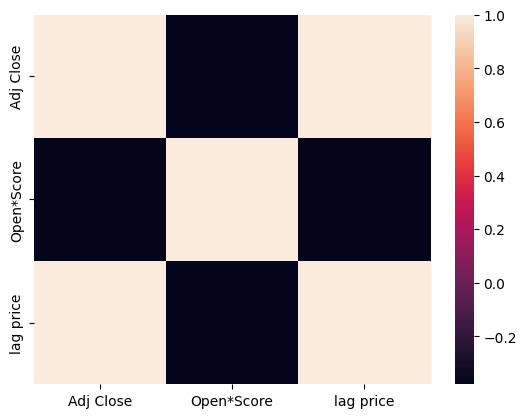

In [8]:
sns.heatmap(df.corr());

#Train and Test Dataset

In [36]:
X=df.drop("Adj Close",axis=1)
Y=df["Adj Close"]
X=X.to_numpy()
X_train,X_test=X[:-48],X[-48:]
Y_train,Y_test=Y[:-48],Y[-48:]
X_train=np.reshape(X_train, (X_train.shape[0],1, X_train.shape[1]))
X_test=np.reshape(X_test, (X_test.shape[0],1, X_test.shape[1]))
Y_train=np.reshape(Y_train, (Y_train.shape[0], 1))
Y_test=np.reshape(Y_test, (Y_test.shape[0],1))
Y_test.shape

(48, 1)

#RNN

In [33]:
SRNN=Sequential()
SRNN.add(SimpleRNN(units = 20,return_sequences = True))
SRNN.add(Dropout(0.1))
SRNN.add(SimpleRNN(units = 20,return_sequences = True))
SRNN.add(SimpleRNN(units = 20,return_sequences = True))
SRNN.add(SimpleRNN(units = 20))
SRNN.add(Dense(units = 1,activation='linear'))
SRNN.compile(loss = "mean_squared_error")
T1=time.time()
SRNN.fit(X_train, Y_train, epochs = 20, batch_size = 20)
T2=time.time()
T_RNN=T2-T1
SRNN.summary()
Y_RNN = SRNN.predict(X_test)
Y_RNN

Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0695
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0261
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0200
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0208
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0220
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0208
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175
Epoch 8/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0192
Epoch 9/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0150
Epoch 10/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0164
Epoch 11/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0151
Epoch 12/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0138
Epoch 13/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0130
Epoch 14/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0138
Epoch 15/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_13 (SimpleRNN)       │ (20, 1, 20)            │           460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (20, 1, 20)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_14 (SimpleRNN)       │ (20, 1, 20)            │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_15 (SimpleRNN)       │ (20, 1, 20)            │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_16 (SimpleRNN)       │ (20, 20)               │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (20, 1)                │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,884 (22.99 KB)

 Trainable params: 2,941 (11.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,943 (11.50 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


array([[0.64382404],
       [0.67316544],
       [0.66052645],
       [0.658895  ],
       [0.5381749 ],
       [0.53977656],
       [0.5593504 ],
       [0.5444895 ],
       [0.56682247],
       [0.5427758 ],
       [0.5776097 ],
       [0.5905803 ],
       [0.53537387],
       [0.5038919 ],
       [0.37294158],
       [0.37035054],
       [0.3324675 ],
       [0.34919012],
       [0.3441351 ],
       [0.37143943],
       [0.3848143 ],
       [0.3392113 ],
       [0.3772247 ],
       [0.32916427],
       [0.3553353 ],
       [0.38227338],
       [0.42020077],
       [0.4081397 ],
       [0.38419124],
       [0.30933094],
       [0.2778086 ],
       [0.31470618],
       [0.4097066 ],
       [0.38226715],
       [0.32418   ],
       [0.28393903],
       [0.16191098],
       [0.11943608],
       [0.15550551],
       [0.21948397],
       [0.21836747],
       [0.31613785],
       [0.32395574],
       [0.35046625],
       [0.3556774 ],
       [0.34833264],
       [0.43202093],
       [0.485

#Deep LSTM

In [34]:
SLSTM=Sequential()
SLSTM.add(LSTM(units = 20,return_sequences = True))
SLSTM.add(Dropout(0.1))
SLSTM.add(LSTM(units = 20,return_sequences = True))
SLSTM.add(LSTM(units = 20,return_sequences = True))
SLSTM.add(LSTM(units = 20))
SLSTM.add(Dense(units = 1))
SLSTM.compile(loss = "mean_squared_error")
T1=time.time()
SLSTM.fit(X_train, Y_train, epochs = 20, batch_size =20)
T2=time.time()
SLSTM.summary()
T_LSTM=T2-T1
Y_LSTM = SLSTM.predict(X_test)
Y_LSTM

Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.9977
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2021
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0289
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0202
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0168
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0132
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0135
Epoch 8/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133
Epoch 9/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123
Epoch 10/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0129
Epoch 11/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112
Epoch 12/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118
Epoch 13/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0135
Epoch 14/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0136
Epoch 15/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (20, 1, 20)            │         1,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (20, 1, 20)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (20, 1, 20)            │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (20, 1, 20)            │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (20, 20)               │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (20, 1)                │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,404 (91.43 KB)

 Trainable params: 11,701 (45.71 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,703 (45.72 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step


array([[0.7059115 ],
       [0.7324485 ],
       [0.7297849 ],
       [0.7238545 ],
       [0.6016359 ],
       [0.6048936 ],
       [0.61378056],
       [0.61470187],
       [0.64145285],
       [0.6123634 ],
       [0.643768  ],
       [0.6544316 ],
       [0.59959203],
       [0.56739193],
       [0.43318292],
       [0.4336049 ],
       [0.39948544],
       [0.41421777],
       [0.41361675],
       [0.4399927 ],
       [0.44255146],
       [0.40567976],
       [0.44587904],
       [0.39084223],
       [0.42431659],
       [0.44990426],
       [0.48120162],
       [0.47271442],
       [0.44733942],
       [0.36992013],
       [0.34236878],
       [0.38483715],
       [0.47245038],
       [0.4499425 ],
       [0.38665006],
       [0.34218377],
       [0.22059594],
       [0.17786376],
       [0.21303432],
       [0.28432596],
       [0.28481242],
       [0.382374  ],
       [0.3846657 ],
       [0.4124429 ],
       [0.41870517],
       [0.4095641 ],
       [0.49533772],
       [0.562

In [54]:
SGRU = Sequential()
SGRU.add(GRU(units=20, return_sequences=True))
SGRU.add(Dropout(0.1))
SGRU.add(GRU(units=20, return_sequences=True))
SGRU.add(GRU(units=20, return_sequences=True))
SGRU.add(GRU(units=20))
SGRU.add(Dense(units=1))
SGRU.compile(loss="mean_squared_error")
T1 = time.time()
SGRU.fit(X_train, Y_train, epochs=20, batch_size=20)
T2 = time.time()
SGRU.summary()
T_GRU = T2 - T1
Y_GRU = SGRU.predict(X_test)
Y_GRU

Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.5985
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0326
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0195
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0241
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0161
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0152
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0130
Epoch 8/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0159
Epoch 9/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0131
Epoch 10/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0140
Epoch 11/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148
Epoch 12/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0214
Epoch 13/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0155
Epoch 14/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115
Epoch 15/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_53 (GRU)                    │ (20, 1, 20)            │         1,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (20, 1, 20)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_54 (GRU)                    │ (20, 1, 20)            │         2,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_55 (GRU)                    │ (20, 1, 20)            │         2,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_56 (GRU)                    │ (20, 20)               │         2,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (20, 1)                │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,044 (70.49 KB)

 Trainable params: 9,021 (35.24 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,023 (35.25 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 778ms/step


array([[0.652936  ],
       [0.681117  ],
       [0.670896  ],
       [0.66833943],
       [0.5490346 ],
       [0.55097467],
       [0.5681472 ],
       [0.5567469 ],
       [0.57983184],
       [0.55491227],
       [0.5886257 ],
       [0.6009286 ],
       [0.5464186 ],
       [0.51500237],
       [0.38313943],
       [0.38115647],
       [0.34363607],
       [0.36014843],
       [0.35596967],
       [0.38336903],
       [0.39458796],
       [0.35035193],
       [0.38922676],
       [0.3391652 ],
       [0.3671935 ],
       [0.39410153],
       [0.4308578 ],
       [0.41949335],
       [0.39509228],
       [0.31880867],
       [0.28757522],
       [0.32627553],
       [0.4206835 ],
       [0.39410487],
       [0.33427793],
       [0.29248226],
       [0.16759652],
       [0.12377905],
       [0.16074643],
       [0.2280458 ],
       [0.22724499],
       [0.32691026],
       [0.33367994],
       [0.36079863],
       [0.3662884 ],
       [0.35848376],
       [0.44319955],
       [0.499

#ESN

In [28]:
rpy.verbosity(0)
rpy.set_seed(42)
reservoir = Reservoir(units=150, lr=0.75, sr=1.25,input_dim=3)
readout=Ridge(ridge=1e-5)
ESN = reservoir >> readout
T1=time.time()
ESN = ESN.fit(X_train, Y_train, warmup=50)
T2=time.time()
Y_ESN=ESN.run(X_test)
T_ESN=T2-T1
Y_ESN

array([[0.69189043],
       [0.71063312],
       [0.70096058],
       [0.69104477],
       [0.58925952],
       [0.60795813],
       [0.59996398],
       [0.60610009],
       [0.62951981],
       [0.58010171],
       [0.62819057],
       [0.61790746],
       [0.5666644 ],
       [0.54858191],
       [0.42527124],
       [0.41506839],
       [0.37770091],
       [0.39893974],
       [0.39476301],
       [0.40684763],
       [0.39734133],
       [0.36352907],
       [0.42112688],
       [0.34959431],
       [0.40621768],
       [0.41626191],
       [0.44639498],
       [0.44587808],
       [0.41396477],
       [0.32345697],
       [0.30371601],
       [0.33678827],
       [0.42276123],
       [0.42466604],
       [0.36509927],
       [0.3072461 ],
       [0.21496474],
       [0.1602451 ],
       [0.19877753],
       [0.27403595],
       [0.27181356],
       [0.35664948],
       [0.36617407],
       [0.38721513],
       [0.39332317],
       [0.37870639],
       [0.47461893],
       [0.543

In [64]:
class QRNNLayer(layers.Layer):
    def __init__(self, hidden_size, kernel_size=2, dropout=0.0):
        super(QRNNLayer, self).__init__()
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
        self.dropout = dropout

    def build(self, input_shape):
        self.conv = layers.Conv1D(3 * self.hidden_size, self.kernel_size, padding='same')
        self.dropout_layer = layers.Dropout(self.dropout)

    @tf.function
    def call(self, x, training=False):
        y = self.conv(x)
        Z, F, O = tf.split(y, 3, axis=-1)
        
        Z = tf.tanh(Z)
        F = tf.sigmoid(F)
        O = tf.sigmoid(O)
        
        h = tf.zeros((tf.shape(x)[0], self.hidden_size))
        
        outputs = tf.TensorArray(tf.float32, size=tf.shape(Z)[1])
        timesteps = tf.shape(Z)[1]
        for t in tf.range(timesteps):
            h = F[:, t, :] * h + (1 - F[:, t, :]) * Z[:, t, :]
            outputs = outputs.write(t, O[:, t, :] * h)
        
        output = outputs.stack()
        output = tf.transpose(output, [1, 0, 2])
        if training:
            output = self.dropout_layer(output, training=training)
        
        return output
class QRNN(models.Model):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.0):
        super(QRNN, self).__init__()
        self.layers_list = [QRNNLayer(hidden_size, dropout=dropout) for _ in range(num_layers)]
        self.fc = layers.Dense(1)

    def call(self, x, training=False):
        for layer in self.layers_list:
            x = layer(x, training=training)
        x = x[:, -1, :]  # Use the last time step's output
        x = self.fc(x)
        return x

input_size = 2
hidden_size = 256
num_layers = 2
dropout = 0.01
model = QRNN(input_size, hidden_size, num_layers=num_layers, dropout=dropout)
model.compile(loss=losses.MeanSquaredError())
T1 = time.time()
model.fit(X_train, Y_train, epochs=20, batch_size=20, validation_split=0.2)
T2 = time.time()
model.summary()
T_QRNN = T2 - T1
Y_QRNN = model.predict(X_test)




Epoch 1/20


C:\Users\fatema\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\optimizers\base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.0856 - val_loss: 0.8023
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0067 - val_loss: 0.8243
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9227 - val_loss: 0.8157
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8376 - val_loss: 0.7918
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8293 - val_loss: 0.7616
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8055 - val_loss: 0.7281
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7529 - val_loss: 0.6900
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7063 - val_loss: 0.6508
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6714 - val_loss: 0.6160
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6085 - val_loss: 0.5767
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5749 - val_loss: 0.5391
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

Model: "qrnn_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ qrnn_layer_20 (QRNNLayer)       │ ?                      │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ qrnn_layer_21 (QRNNLayer)       │ ?                      │       393,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (20, 1)                │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 796,164 (3.04 MB)

 Trainable params: 398,081 (1.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 398,083 (1.52 MB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 430ms/step


#Perfomance Comparison

In [59]:
pred=df.iloc[-48:,0].to_frame()
pred = pred.rename(columns={"Adj Close": "Actual"})
pred["RNN"]=Y_RNN
pred["LSTM"]=Y_LSTM
pred["GRU"]=Y_GRU
pred["QRNN"]=Y_QRNN
pred["ESN"]=Y_ESN
pred=((S*pred)+M)
pred

,Actual,RNN,LSTM,GRU,QRNN,ESN
Date,,,,,,
12-04-2024,85.660004,83.930840,85.291130,84.130478,76.856468,84.983934
15-04-2024,85.410004,84.573685,85.872528,84.747894,77.242477,85.394572
16-04-2024,85.360001,84.296776,85.814178,84.523964,77.032715,85.182654
17-04-2024,82.690002,84.261032,85.684242,84.467949,77.031754,84.965406
18-04-2024,82.730003,81.616150,83.006531,81.854073,75.511963,82.735370
19-04-2024,83.139999,81.651237,83.077904,81.896576,75.524628,83.145042
22-04-2024,82.849998,82.080086,83.272606,82.272820,75.830902,82.969897
23-04-2024,83.360001,81.754494,83.292793,82.023041,75.562798,83.104334
24-04-2024,82.809998,82.243790,83.878891,82.528816,75.829224,83.617442


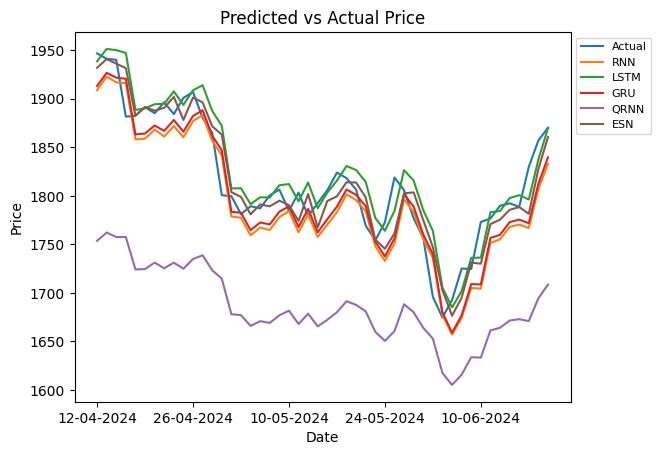

In [70]:
((S*pred)+M).plot()
plt.title("Predicted vs Actual Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 8}) ;


In [61]:
def met(df):

    actual = df.iloc[:, 0]
    values = {
        'Model': [],
        'MSE': [],
        'RMSE': [],
        'R-squared': []
    }
    for c in df.columns[1:]:
        y_a = actual
        y_p = df[c]
        mse = mean_squared_error(y_a, y_p)
        rmse = np.sqrt(mse)
        r_squared = r2_score(y_a, y_p)
        values['Model'].append(c)
        values['MSE'].append(mse)
        values['RMSE'].append(rmse)
        values['R-squared'].append(r_squared)

    values = pd.DataFrame(values)
    values.set_index("Model",inplace=True)
    return values
perf=met(pred).round(4)
T=[T_RNN,T_LSTM,T_GRU,T_ESN,T_QRNN]
perf["Time"]=T
perf

,MSE,RMSE,R-squared,Time
Model,,,,
RNN,2.1224,1.4568,0.7513,11.426057
LSTM,1.3735,1.1720,0.8391,14.418621
GRU,1.7383,1.3184,0.7963,12.735665
QRNN,36.5585,6.0464,-3.2836,1.290877
ESN,1.1845,1.0883,0.8612,9.901094


In [63]:
class SmaCross(Strategy):
    n1 = 5
    n2 = 20

    def init(self):
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.sell()
def dat(x):
    df = yf.download("CL=F", start="2024-04-12", end="2024-06-21")
    df.drop(columns=["Adj Close","Close"], inplace=True)
    back=pd.DataFrame(pred[x])
    back.index=df.index
    df["Close"]=back[x]
    df=df[['Open', 'High', 'Low', 'Close', 'Volume']]
    bt = Backtest(df, SmaCross, cash=10_000, commission=.002)
    stats = bt.run()
    equity_final = stats['Equity Final [$]']
    return_percent = stats['Return [%]']
    buy_and_hold_return_percent = stats['Buy & Hold Return [%]']
    data = {
    'Equity Final [$]': [equity_final],
    'Return [%]': [return_percent],
    'Buy & Hold Return [%]': [buy_and_hold_return_percent],

    }
    stats_df = pd.DataFrame(data)
    return stats_df
def final(y):
    result = pd.DataFrame()
    for x in y.columns:
        x_values = dat(x)
        result = pd.concat([result, x_values], ignore_index=True)
    result.index = y.columns
    return result
Result = final(pred)
Result["P&L"]=pred.iloc[-1] - pred.iloc[0]
Result



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\fatema\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\backtesting\_stats.py:122: RuntimeWarning: divide by zero encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Equity Final [$],Return [%],Buy & Hold Return [%],P&L
Actual,10435.721928,4.357219,-4.074253,-3.490005
RNN,10366.145226,3.661452,-4.123959,-3.461273
LSTM,10366.145226,3.661452,-3.690882,-3.147995
GRU,10366.145226,3.661452,-3.988048,-3.355164
QRNN,10366.145226,3.661452,-2.683385,-2.062355
ESN,10366.145226,3.661452,-3.827126,-3.252443
